<a href="https://colab.research.google.com/github/lnsayer/udemy_ml_course/blob/main/04_PyTorch_Custom_Datasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing PyTorch and setting up device-agnostic code

In [2]:
import torch
from torch import nn

# Note: this notebook requires torch >= 1.10.0
torch.__version__

'2.2.1+cu121'

In [3]:
# Setup device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

The data we're going to be using is a subset of the Food101 dataset https://data.vision.ee.ethz.ch/cvl/datasets_extra/food-101/

In [4]:
import requests
import zipfile
from pathlib import Path


# Setup path to dataa folder
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# If the image folder doesn't exist, download it and prepare it...
if image_path.is_dir():
  print(f"{image_path} directory exists.")
else:
  print(f"Did not find {image_path} directory, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

  # Download pizza, steak, sushi data
  with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
    request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
    print("Downloading pizza, steak, sushi data...")
    f.write(request.content)

    #Unzip pizza, steak, sushi data
    with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
      print("Unzipping pizza, steak, sushi data...")
      zip_ref.extractall(image_path)

data/pizza_steak_sushi directory exists.


## 2. Become one with the data (data preparation)

We can inspect what's in our data directory by writing a small helper function to walk through each of the subdirectories and count the files present

In [5]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  Returns:
    A print out of:
    number of subdirectories in dir_path
    number of images (files) in each subdirectory
    name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


In [6]:
walk_through_dir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.


In [7]:
# Setup train and testing paths
train_dir = image_path / "train"
test_dir = image_path / "test"

train_dir, test_dir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

Random image path: data/pizza_steak_sushi/train/steak/2013535.jpg
Image Class: steak
Image height: 512
Image width: 512


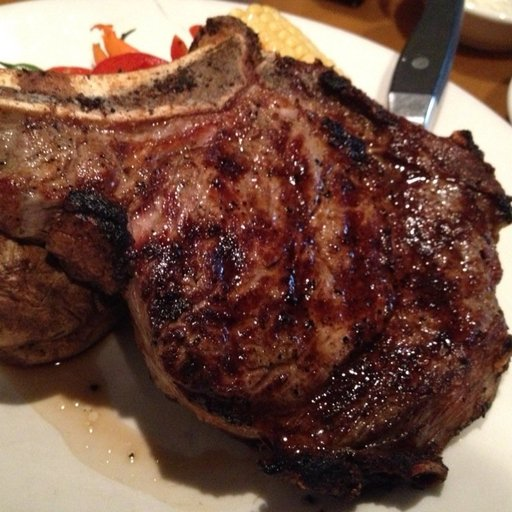

In [8]:
import random
from PIL import Image

# Set seed
random.seed(42) # <- try changing this and see what happens

# 1. Get all image paths (* means "any combination")
image_path_list = list(image_path.glob("*/*/*.jpg"))

# 2. Get random image path
random_image_path = random.choice(image_path_list)

# 3. Get image class from path name (the image class is the name of the directory where the image is stored)
image_class = random_image_path.parent.stem

# 4. Open image
img = Image.open(random_image_path)

# 5. Print metadata
print(f"Random image path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

We can do the same with `matplotlib.pyplot.imshow()`, except we have to convert the image to a NumPy array first

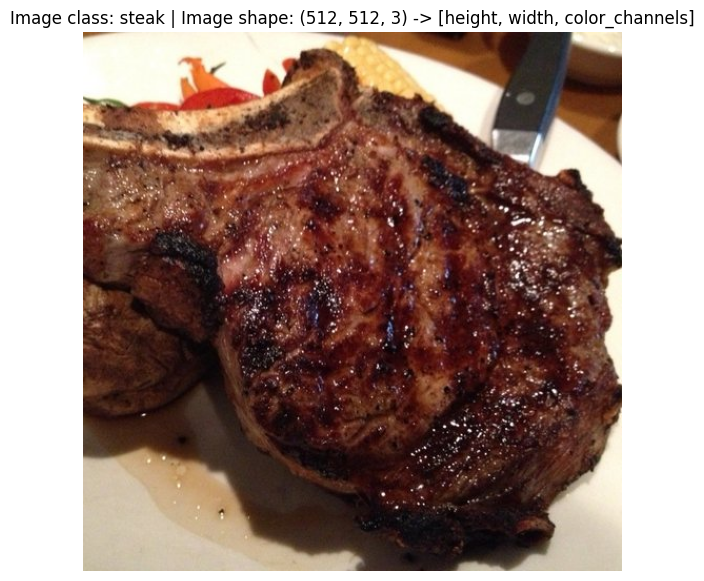

In [9]:
import numpy as np
import matplotlib.pyplot as plt


# Turn the image into an array
img_as_array = np.asarray(img)

#Plot the image with matplotlib
plt.figure(figsize=(10,7))
plt.imshow(img_as_array)
plt.title(f"Image class: {image_class} | Image shape: {img_as_array.shape} -> [height, width, color_channels]")
plt.axis(False);

## Transforming data

Before we can use our image data with PyTorch we need to:
1. Turn it into tensors
2. Turn it into `torch.utils.data.Dataset` and subsequently a `torch.utils.data.DataLoader`, we'll call these `Dataset` and `DataLoader` for short.

In [10]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

## 3.1 Transforming data with `torchvision.transforms`

In [11]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(64, 64)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip
    # Turn the image into a Torch.tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0
])

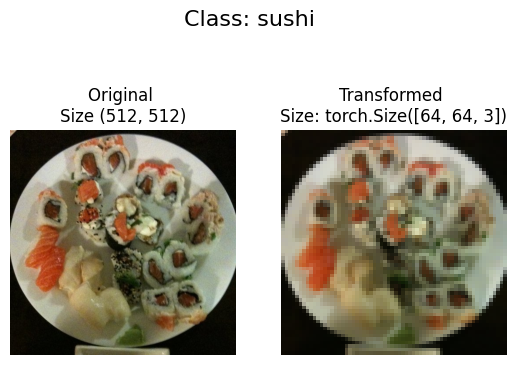

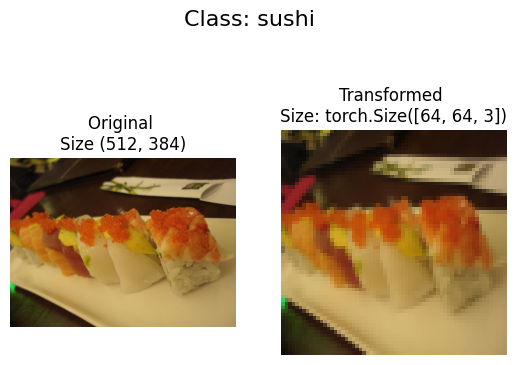

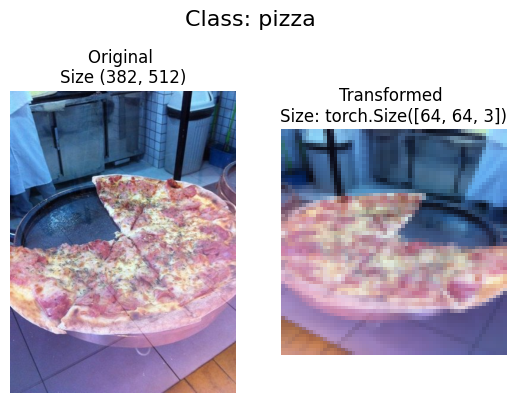

In [12]:
def plot_transformed_images(image_paths, transform, n=3, seed=42):
  """Plots a series of random images from image_paths.

  Will open n image paths from image_paths, transform them
  with transform and plot them side by side.

  Args:
  image_paths (list): List of target image paths.
  transform (PyTorch Transforms): Transforms to apply to images.
  n (int, optional): Number of images to plot. Defaults to 3.
  seed (int, optional): Random seed for the random generator. Defaults to 42.
  """

  random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original \nSize {f.size}")
      ax[0].axis("off")

      # Transform and plot image
      # Note: permute() wil change shape of image to suit matplotlib
      # (PyTorch default is [C, H, W] but Matplotlib is[H, W, C])
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed \nSize: {transformed_image.shape}")
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize=16)

plot_transformed_images(image_path_list,
                        transform = data_transform,
                        n=3,
                        seed=39)

# 4. Option 1: Loading Image Data using `ImageFolder`


Since our data is in standard image classification format, we can use the class `torchvision.datasets.ImageFolder`.

In [13]:
# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)
test_data = datasets.ImageFolder(root=test_dir,
                                 transform=data_transform)

print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 225
    Root location: data/pizza_steak_sushi/train
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 75
    Root location: data/pizza_steak_sushi/test
    StandardTransform
Transform: Compose(
               Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [14]:
# Get class names as a list
class_names = train_data.classes
class_names

['pizza', 'steak', 'sushi']

In [15]:
# can also get class names as a dict
class_dict = train_data.class_to_idx
class_dict

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [16]:
# Check the lengths
len(train_data), len(test_data)

(225, 75)

We can index on our `train_data` and `test_data` `Dataset`'s to find samples and their target labels.

In [17]:
img, label = train_data[0][0], train_data[0][1]
print(f"Image tensor:\n{img}")
print(f"Image shape: {img.shape}")
print(f"Image datatype: {img.dtype}")
print(f"Image label: {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0902],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0745],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0157,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.09

Let's plot a single image tensor using `Matplotlib`

Original shape: torch.Size([3, 64, 64]) -> [color_channels, height, width]
Image permute shape: torch.Size([64, 64, 3]) -> [height, width, color_channels]


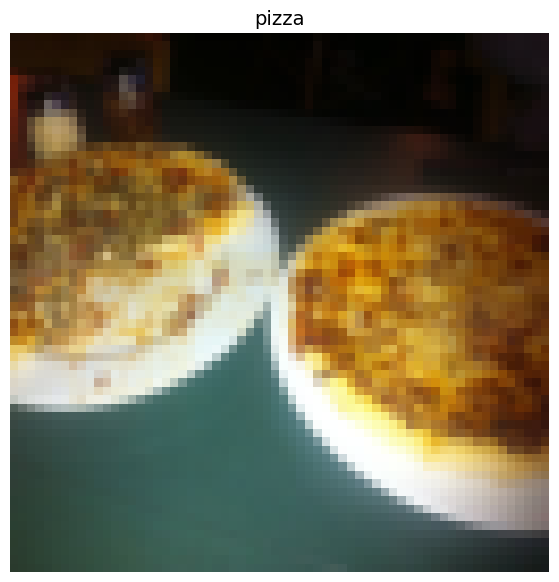

In [18]:
# Rearrange the order of dimensions
img_permute = img.permute(1, 2, 0)

# Print out different shapes (before and after permute)
print(f"Original shape: {img.shape} -> [color_channels, height, width]")
print(f"Image permute shape: {img_permute.shape} -> [height, width, color_channels]")

# Plot the image
plt.figure(figsize=(10,7))
plt.imshow(img.permute(1,2,0));
plt.axis("off")
plt.title(class_names[label], fontsize=14);

# 4.1 Turn loaded images into `DataLoader`s

In [19]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data,
                              batch_size=1, # how many samples per batch
                              num_workers=1, # how many subprocessesto use for data loading (higher=more)
                              shuffle=True) #shuffle the data?
test_dataloader = DataLoader(dataset=test_data,
                             batch_size=1,
                             num_workers=1,
                             shuffle=False) # don't usually need to shuffle testing data
train_dataloader, test_dataloader


(<torch.utils.data.dataloader.DataLoader at 0x7e472dcde110>,
 <torch.utils.data.dataloader.DataLoader at 0x7e472dcdd840>)

In [20]:
img, label = next(iter(train_dataloader))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img.shape} -> [batch_size, color_channels, height, width]")
print(f"Label shape: {label.shape}")

/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Label shape: torch.Size([1])


## 5. Option 2: Loading Image data with a Custom `Dataset`

We'll start by importing the modules we need:

- Python's `os` for dealing with directories (our data is stored in directories).
- Python's `pathlib` for dealing with filepaths (each of our images has a unique filepath).
- `torch` for all things PyTorch.
- PIL's `Image` class for loading images.
- `torch.utils.data.Dataset` to subclass and create our own custom `Dataset`.
- `torchvision.transforms` to turn our images into tensors.
- Various types from Python's `typing` module to add type hints to our code.

In [21]:
import os
import pathlib
import torch

from PIL import Image
from torch.utils.data import Dataset
from torchvision import transforms
from typing import Tuple, Dict, List

In [22]:
# Instance of torchvision.datasets.ImageFolder()
train_data.classes, train_data.class_to_idx

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 5.1 Creating a helper function to get class names


In [23]:
# Setup path for target directory
target_directory = train_dir
print(f"Target directory: {target_directory}")

# Get the class names from the target directory
class_names_found = sorted([entry.name for entry in list(os.scandir(image_path / "train"))])
print(f"Class names found: {class_names_found}")

Target directory: data/pizza_steak_sushi/train
Class names found: ['pizza', 'steak', 'sushi']


In [24]:
# Make function to find classes in target directory
def find_classes(directory: str) -> Tuple[List[str], Dict[str, int]]:
  """ Finds the class folder names in a target directory.

  Assumes target directory is in standard image classification format.

  Args:
    directory (str): target directory to load classnames from.
  Returns:
    Tuple[List[str]], Dict[str, int]]: (list_of_class_names, dict(class_name:idx...))

  Example:
    find_classes("food_images/train")
    >>> (["class_1", "class_2"], {"class_1": 0, ...})
  """
  # 1. Get the class names by scanning the target directory
  classes = sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

  # 2. Raise an error if class names not found
  if not classes:
    raise FileNotFoundError(f"Couldn't find any classes in {directory}.")

  #3. Create a dictionary of index labels (computer prefer numerical rather than string labels)
  class_to_idx = {cls_name: i for i, cls_name in enumerate(classes)}

  return classes, class_to_idx

In [25]:
find_classes(train_dir)

(['pizza', 'steak', 'sushi'], {'pizza': 0, 'steak': 1, 'sushi': 2})

## 5.2 Create a custom `Dataset` to replicate `ImageFolder`

In [26]:
# Write a custom dataset class (inherits from torch.utils.data.Dataset)
from torch.utils.data import Dataset

# 1. Subclass torch.utils.data.Dataset
class ImageFolderCustom(Dataset):

  # 2. Initialise with a targ_dir and transform (optional) parameter
  def __init__(self, targ_dir: str, transform=None)->None:

    # 3. Create class attributes
    # Get all image paths
    self.paths = list(pathlib.Path(targ_dir).glob("*/*.jpg")) # note you'd have to update this if you've got .png's or .jpeg's
    # Setup transforms
    self.transform = transform
    # Create classes and class_to_idx attributes
    self.classes, self.class_to_idx = find_classes(targ_dir)

  # 4. Make function to load images
  def load_image(self, index:int) -> Image.Image:
    "Opens an image via a path and returns it."
    image_path = self.paths[index]

    return Image.open(image_path)

  # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
  def __len__(self) -> int:
    "Returns the total number of samples."
    return len(self.paths)

  # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
  def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
    "Returns one sample of data, data and label (X, y)."
    img = self.load_image(index)
    class_name = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
    class_idx = self.class_to_idx[class_name]

    # Transform if necessary
    if self.transform:
      return self.transform(img), class_idx # return data, label (X,y)
    else:
      return img, class_idx # return data, label (X, y)

Let's create some transforms to prepare our images.

In [27]:
# Augment train data
train_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

# Don't augment test data, only reshape
test_transforms = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

Let's turn our training images (contained in `train_dir`) and our testing images (contained in `test_dir`) into `Dataset`'s using our own `ImageFolderCustom` class.

In [28]:
train_data_custom = ImageFolderCustom(targ_dir= train_dir,
                                      transform=train_transforms)
test_data_custom = ImageFolderCustom(targ_dir = test_dir,
                                     transform = test_transforms)
train_data_custom, test_data_custom

(<__main__.ImageFolderCustom at 0x7e472dd3d720>,
 <__main__.ImageFolderCustom at 0x7e472dd3dcc0>)

In [29]:
len([3,4,5])

3

In [30]:
[3,4,5].__len__()

3

In [31]:
len(train_data_custom), len(test_data_custom)

(225, 75)

In [32]:
train_data_custom.classes

['pizza', 'steak', 'sushi']

In [33]:
train_data_custom.class_to_idx

{'pizza': 0, 'steak': 1, 'sushi': 2}

In [34]:
# Check for equality amongst our custom Dataset and ImageFolder Dataset
print((len(train_data_custom) == len(train_data)) & (len(test_data_custom) == len(test_data)))
print(train_data_custom.classes == train_data.classes)
print(train_data_custom.class_to_idx == train_data.class_to_idx)

True
True
True


Let's plot some random images to test our `__getitem__` override

## 5.3 Create a function to display random images

### My version of display_random_images

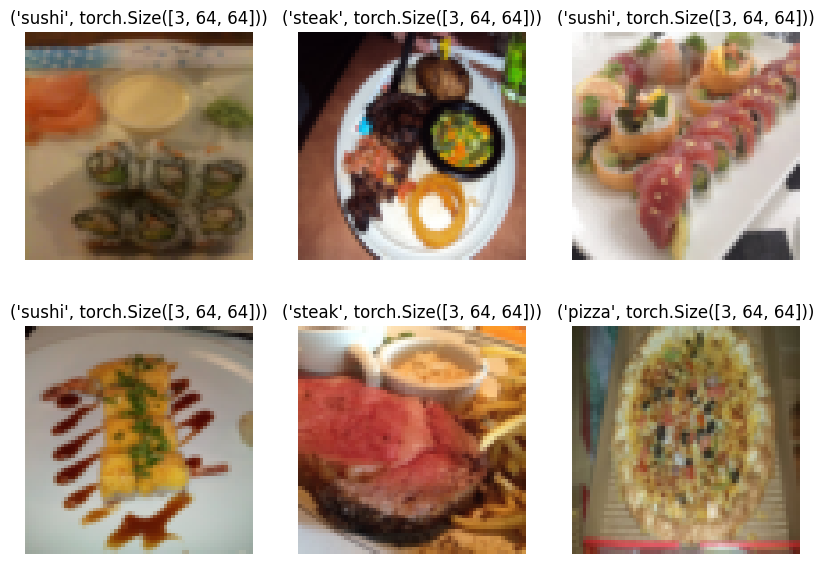

In [35]:
def display_random_images(dataset, classes, n=6, seed=42):
  """
  Produces a subplot of images of dataset and

  Args:
  dataset: pytorch dataset to load images from
  classes:
  n: number of plots in subplot
  seed: random seed to pick random images

  Returns: subplot of images
  """

  plot_cols = int(n/2) + (n % 2 > 0)
  torch.manual_seed(seed)

  plt.figure(figsize=(10,7))
  for i in range(1, n+1):
    rand_index = torch.randint(1,len(dataset), (1,)).item()
    image, label = dataset[rand_index]
    plt.subplot(2, plot_cols, i)
    plt.imshow(image.permute(1,2,0))
    title = class_names[label], image.shape
    plt.title(title)

    plt.axis(False)

display_random_images(train_data_custom, train_data_custom.classes)






### Daniel Bourke's version of display_random_images

In [36]:
# Take in a dataset as well as a list of class names
def display_random_images(dataset: torch.utils.data.dataset.Dataset,
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          seed: int = None):

  # 2. Adjust display if n too high
  if n > 10:
    n = 10
    display_shape = False
    print(f"For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display")

  # 3. Set random seed
  if seed:
    random.seed(seed)

  # 4. Get random sample indexes
  random_samples_idx = random.sample(range(len(dataset)), k =n)
  # print(random_samples_idx)

  # 5. Setup plot
  plt.figure(figsize=(16,8))

  # 6. Loop through samples and display random samples
  for i, targ_sample in enumerate(random_samples_idx):
    # print(i, targ_sample)
    targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

    # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
    targ_image_adjust = targ_image.permute(1, 2, 0)

    # Plot adjusted samples
    plt.subplot(1, n, i+1)
    plt.imshow(targ_image_adjust)
    plt.axis("off")
    if classes:
      title = f"class: {classes[targ_label]}"
      if display_shape:
        title = title + f"\nshape: {targ_image_adjust.shape}"
    plt.title(title)


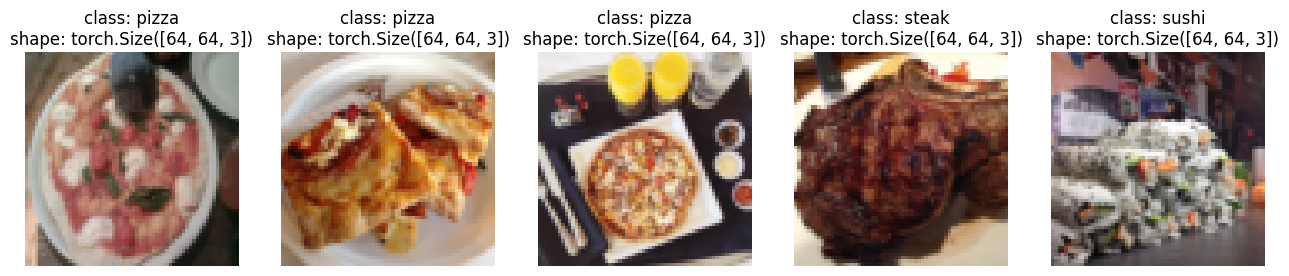

In [37]:
# Display random images from ImageFolder created Dataset
display_random_images(train_data,
                      n=5,
                      classes = class_names,
                      seed=None)

For display purposes, n shouldn't be larger than 10, setting to 10 and removing shape display


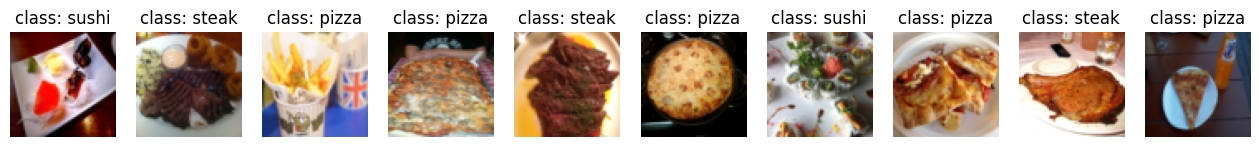

In [38]:
# Display random images from ImageFolderCustom Dataset
display_random_images(train_data_custom,
                      n=12,
                      classes = class_names,
                      seed=None) # Try setting the seed for reproducible results

# 5.4 Turn custom loaded images into `DataLoader`'s

In [39]:
# Turn train and test custom Datasets into DataLoaders

from torch.utils.data import DataLoader
train_dataloader_custom = DataLoader(dataset = train_data_custom, # use custom created train Dataset
                                      batch_size = 1, # how many samples per batch?
                                      num_workers = 0, # how many subprocesses to use for data loading? (higher = more)
                                      shuffle =True) # shuffle the data?
test_dataloader_custom = DataLoader(dataset = test_data_custom,
                                    batch_size=1,
                                    num_workers=0,
                                    shuffle=False) # don't usually need to shuffle testing data
train_dataloader_custom, test_dataloader_custom

(<torch.utils.data.dataloader.DataLoader at 0x7e472d991570>,
 <torch.utils.data.dataloader.DataLoader at 0x7e472d992bc0>)

In [40]:
# Get image and label from custom DataLoader
img_custom, label_custom = next(iter(train_dataloader_custom))

# Batch size will now be 1, try changing the batch_size parameter above and see what happens
print(f"Image shape: {img_custom.shape} -> [batch_size, color_channels, height, width]")
print(f"Image label shape: {label_custom.shape}")

Image shape: torch.Size([1, 3, 64, 64]) -> [batch_size, color_channels, height, width]
Image label shape: torch.Size([1])


## 6. Other forms of transforms (data augmentation)


The purpose of transforms is to alter your images in some way

**Data augmentation** is the process of altering your data in such a way that you *artificially* increase the diversity of your training set.

The main parameter to pay attention to in `transforms.TrivialAugmentWide()` is `num_magnitude_bins=31`

In [41]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31), # how intense
    transforms.ToTensor() # use ToTensor() last to get everything between 0 and 1
])

# Don't need to perform augmentation on the test data
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

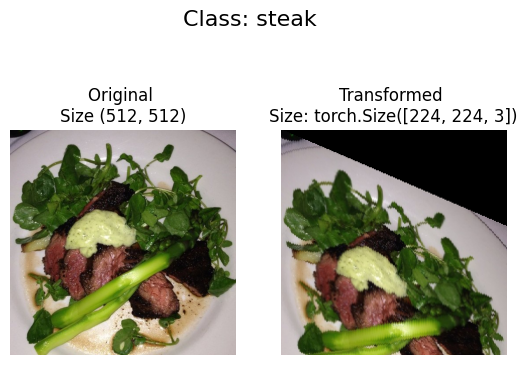

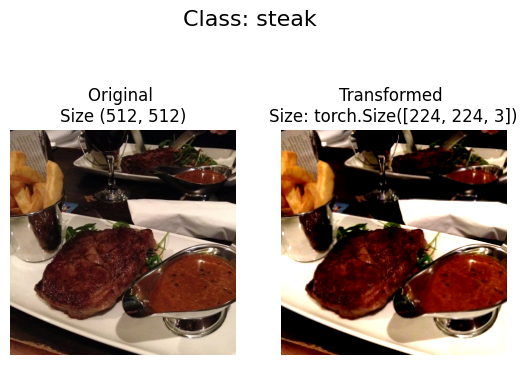

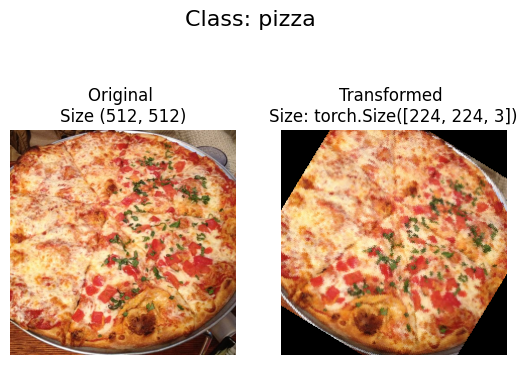

In [42]:
# Get all image paths
image_path_list = list(image_path.glob("*/*/*.jpg"))

# Plot random images
plot_transformed_images(
    image_paths = image_path_list,
    transform = train_transforms,
    n=3,
    seed = None
)

# 7. Model 0: TinyVGG without data augmentation


## 7.1 Creating transforms and loading data for model 0


In [43]:
# Create simple transform
simple_transform = transforms.Compose([
    transforms.Resize((64,64)),
    transforms.ToTensor()
])

Let's:
1. Load the data, turning each of our training and test folders first into a `Dataset` with torchvision.datasets.ImageFolder()
2. Then into a `DataLoader` using `torch.utils.data.DataLoader()`.
- We'll set the `batch_size=32` and `num_workers` to as many CPUs on our machine (this will depend on what machine you're using).

In [44]:
# 1. Load and transform data
from torchvision import datasets
train_data_simple = datasets.ImageFolder(root=train_dir,
                                         transform=simple_transform)
test_data_simple = datasets.ImageFolder(root=test_dir,
                                        transform=simple_transform)

# 2. Turn data into DataLoaders
import os
from torch.utils.data import DataLoader

# Setup batchsize and number of workers
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()
print(NUM_WORKERS)
print(f"Creating DataLoaders with batch size {BATCH_SIZE} and {NUM_WORKERS} workers.")

# Create DataLoaders
train_dataloader_simple = DataLoader(train_data_simple,
                                     batch_size = BATCH_SIZE,
                                     shuffle=True,
                                     num_workers=NUM_WORKERS)
test_dataloader_simple = DataLoader(test_data_simple,
                                    batch_size = BATCH_SIZE,
                                    shuffle=False,
                                    num_workers = NUM_WORKERS)
train_dataloader_simple, test_dataloader_simple

2
Creating DataLoaders with batch size 32 and 2 workers.


(<torch.utils.data.dataloader.DataLoader at 0x7e472da55db0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e472d9933a0>)

## 7.2 Create TinyVGG model class

In [45]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from:
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from?
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*16*16,
                      out_features=output_shape)
        )

    def forward(self, x: torch.Tensor):
        """
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        """
        return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion

torch.manual_seed(42)
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB)
                  hidden_units=10,
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

## 7.3 Try a forward pass on a single image (to test the model)

In [46]:
img_batch, label_batch = next(iter(train_dataloader_simple))
single_img = img_batch[0].unsqueeze(dim=0).to(device)
single_label = label_batch[0].to(device)

print(f"Single image shape is: {single_img.shape}")

model_0.eval()
model_0.to(device)
with torch.inference_mode():
  y_logits = model_0.forward(single_img)

y_probs = torch.softmax(y_logits, dim=1)
y_preds = torch.argmax(y_probs)

print(f"\nImage logits are:\n {y_logits}")
print(f"\nImage probabilities are:\n {y_probs}")
print(f"\nImage prediction class is:\n {y_preds}")
print(f"\nActual label: {single_label}")



Single image shape is: torch.Size([1, 3, 64, 64])

Image logits are:
 tensor([[0.0578, 0.0634, 0.0351]])

Image probabilities are:
 tensor([[0.3352, 0.3371, 0.3277]])

Image prediction class is:
 1

Actual label: 2


## 7.4 use `torchinfo` to get an idea of the shapes going through our model

In [47]:
try:
  import torchinfo
except:
  !pip install torchinfo
  import torchinfo
from torchinfo import summary
summary(model_0, input_size=[1,3,64, 64]) # do a test pass through of an example input size

Layer (type:depth-idx)                   Output Shape              Param #
TinyVGG                                  [1, 3]                    --
├─Sequential: 1-1                        [1, 10, 32, 32]           --
│    └─Conv2d: 2-1                       [1, 10, 64, 64]           280
│    └─ReLU: 2-2                         [1, 10, 64, 64]           --
│    └─Conv2d: 2-3                       [1, 10, 64, 64]           910
│    └─ReLU: 2-4                         [1, 10, 64, 64]           --
│    └─MaxPool2d: 2-5                    [1, 10, 32, 32]           --
├─Sequential: 1-2                        [1, 10, 16, 16]           --
│    └─Conv2d: 2-6                       [1, 10, 32, 32]           910
│    └─ReLU: 2-7                         [1, 10, 32, 32]           --
│    └─Conv2d: 2-8                       [1, 10, 32, 32]           910
│    └─ReLU: 2-9                         [1, 10, 32, 32]           --
│    └─MaxPool2d: 2-10                   [1, 10, 16, 16]           --
├─Sequentia

## 7.5 Create train and test loop functions

In [48]:
def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [49]:
def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

## 7.6 Creating a `train()` function to combine `train_step()` and `test_step()`

In [50]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):

  # 2. Create empty results dictionary
  results = {"train_loss": [],
             "train_acc": [],
             "test_loss": [],
             "test_acc": []
             }
  # 3. Loop through training and testing steps for a number of epochs
  for epoch in tqdm(range(epochs)):
    train_loss, train_acc = train_step(model=model,
                                       dataloader=train_dataloader,
                                       loss_fn = loss_fn,
                                       optimizer=optimizer)
    test_loss, test_acc = test_step(model=model,
                                    dataloader=test_dataloader,
                                    loss_fn=loss_fn)
    # 4. Print out what's happening
    print(
        f"Epoch: {epoch+1} |"
        f"train_loss: {train_loss:.4f} |"
        f"train_acc: {train_acc:.4f} |"
        f"test_loss: {test_loss:.4f} |"
        f"test_acc: {test_acc:.4f}"
    )

    # 5. Update results dictionary
    results["train_loss"].append(train_loss)
    results["train_acc"].append(train_acc)
    results["test_loss"].append(test_loss)
    results["test_acc"].append(test_acc)

  # 6. Return the filled results at the end of the epochs
  return results

## 7.7 Train and Evaluate Model 0



In [51]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 15

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB))
                  hidden_units=10,
                  output_shape = len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_0
model_0_results = train(model=model_0,
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 1.1078 |train_acc: 0.2578 |test_loss: 1.1362 |test_acc: 0.2604
Epoch: 2 |train_loss: 1.0846 |train_acc: 0.4258 |test_loss: 1.1622 |test_acc: 0.1979
Epoch: 3 |train_loss: 1.1153 |train_acc: 0.2930 |test_loss: 1.1695 |test_acc: 0.1979
Epoch: 4 |train_loss: 1.0990 |train_acc: 0.2891 |test_loss: 1.1343 |test_acc: 0.1979
Epoch: 5 |train_loss: 1.0990 |train_acc: 0.2930 |test_loss: 1.1434 |test_acc: 0.1979
Epoch: 6 |train_loss: 1.0964 |train_acc: 0.3125 |test_loss: 1.1483 |test_acc: 0.2604
Epoch: 7 |train_loss: 1.1187 |train_acc: 0.3203 |test_loss: 1.1423 |test_acc: 0.3125
Epoch: 8 |train_loss: 1.1015 |train_acc: 0.3555 |test_loss: 1.1051 |test_acc: 0.1979
Epoch: 9 |train_loss: 1.0893 |train_acc: 0.4688 |test_loss: 1.0687 |test_acc: 0.5417
Epoch: 10 |train_loss: 1.0683 |train_acc: 0.4023 |test_loss: 1.0169 |test_acc: 0.5417
Epoch: 11 |train_loss: 1.0487 |train_acc: 0.4062 |test_loss: 0.9751 |test_acc: 0.5729
Epoch: 12 |train_loss: 1.1047 |train_acc: 0.3672 |test_loss: 1.

## 7.8 Plot the loss curves of Model 0



In [52]:
# Check the model_0_results keys
model_0_results.keys()

dict_keys(['train_loss', 'train_acc', 'test_loss', 'test_acc'])

In [53]:
def plot_loss_curves(results: Dict[str, List[float]]):
  """ Plots training curves of a results dictionary.

  Args:
      results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
  """
  # Get the loss values of the results dictionary (training and test)
  loss = results['train_loss']
  test_loss = results['test_loss']

  # Get the accuracy values of the results dictionary (training and test)
  accuracy = results['train_acc']
  test_acc = results['test_acc']

  # Figure out how many epochs there were
  epochs = range(len(loss))

  # Setup a plot
  plt.figure(figsize=(15,7))

  # Plot loss
  plt.subplot(1,2,1)
  plt.plot(epochs, loss, label='train_loss')
  plt.plot(epochs, test_loss, label='test_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.subplot(1,2,2)
  plt.plot(epochs,accuracy, label='train_accuracy')
  plt.plot(epochs, test_acc, label='test_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();


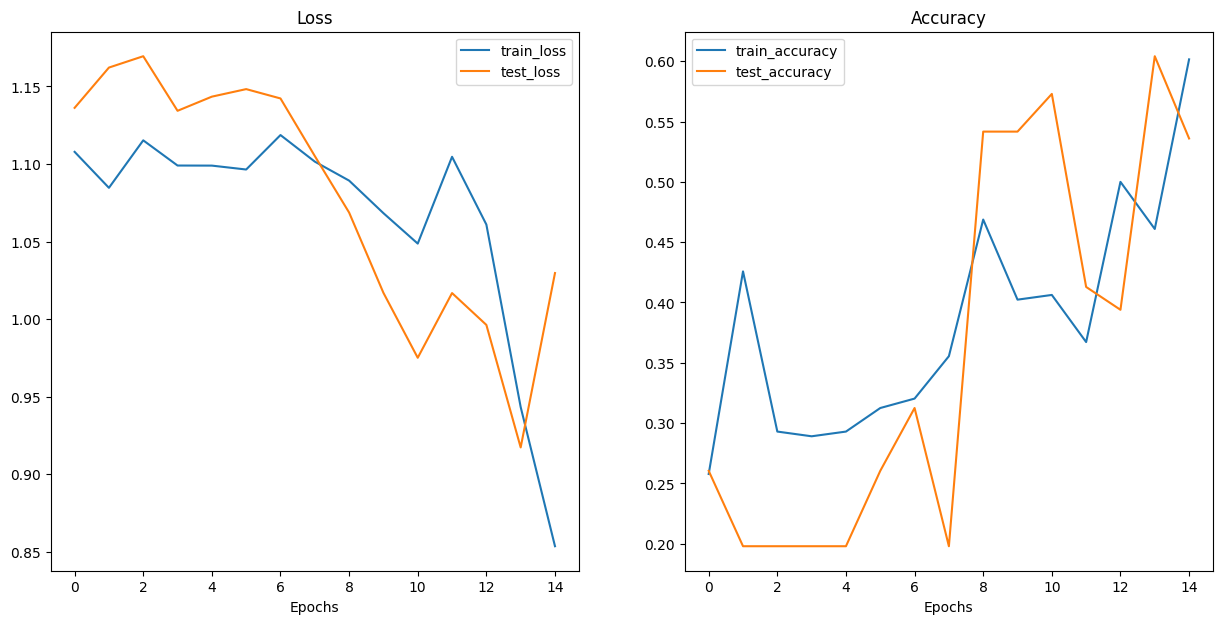

In [54]:
plot_loss_curves(model_0_results)

## 9.1 Create transform with data augmentation

In [55]:
# Create training transform with TrivialAugment
train_transform_trivial_augment = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor()
])

# Create testing transform (no data augmentation)
test_transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

## 9.2 Create train and test `Dataset`s and `DataLoader`s

In [56]:
# Turn image folders into datasets
train_data_augmented = datasets.ImageFolder(train_dir, transform = train_transform_trivial_augment)
test_data_simple = datasets.ImageFolder(test_dir, transform=test_transform)

train_data_augmented, test_data_simple

(Dataset ImageFolder
     Number of datapoints: 225
     Root location: data/pizza_steak_sushi/train
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
            ),
 Dataset ImageFolder
     Number of datapoints: 75
     Root location: data/pizza_steak_sushi/test
     StandardTransform
 Transform: Compose(
                Resize(size=(64, 64), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
            ))

In [57]:
# Turn datasets into Dataloader's
import os
BATCH_SIZE = 32
NUM_WORKERS = os.cpu_count()

torch.manual_seed(42)
train_dataloader_augmented = DataLoader(train_data_augmented,
                                        batch_size=BATCH_SIZE,
                                        shuffle=True,
                                        num_workers=NUM_WORKERS)
test_dataloader_augmented = DataLoader(test_data_simple,
                                       batch_size=BATCH_SIZE,
                                       shuffle=False,
                                       num_workers=NUM_WORKERS)

train_dataloader_augmented, test_dataloader_augmented

(<torch.utils.data.dataloader.DataLoader at 0x7e472df4c2b0>,
 <torch.utils.data.dataloader.DataLoader at 0x7e472dba7b80>)

In [58]:
# Create model_1 and send it to the target device
torch.manual_seed(42)
model_1 = TinyVGG(
    input_shape=3,
    hidden_units=10,
    output_shape=len(train_data_augmented.classes)).to(device)
model_1

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=2560, out_features=3, bias=True)
  )
)

In [59]:
# Set random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Set number of epochs
NUM_EPOCHS = 15

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_1.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer
start_time = timer()

# Train model_1
model_1_results = train(model=model_1,
                        train_dataloader=train_dataloader_augmented,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn,
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 1 |train_loss: 1.1076 |train_acc: 0.2500 |test_loss: 1.1062 |test_acc: 0.2604
Epoch: 2 |train_loss: 1.0791 |train_acc: 0.4258 |test_loss: 1.1387 |test_acc: 0.2604
Epoch: 3 |train_loss: 1.0810 |train_acc: 0.4258 |test_loss: 1.1696 |test_acc: 0.2604
Epoch: 4 |train_loss: 1.1292 |train_acc: 0.3047 |test_loss: 1.1625 |test_acc: 0.2604
Epoch: 5 |train_loss: 1.0899 |train_acc: 0.4258 |test_loss: 1.1482 |test_acc: 0.2604
Epoch: 6 |train_loss: 1.0953 |train_acc: 0.3047 |test_loss: 1.1437 |test_acc: 0.2604
Epoch: 7 |train_loss: 1.0874 |train_acc: 0.4023 |test_loss: 1.1391 |test_acc: 0.1979
Epoch: 8 |train_loss: 1.1062 |train_acc: 0.2930 |test_loss: 1.1491 |test_acc: 0.1979
Epoch: 9 |train_loss: 1.1202 |train_acc: 0.3281 |test_loss: 1.1534 |test_acc: 0.3021
Epoch: 10 |train_loss: 1.0744 |train_acc: 0.5234 |test_loss: 1.0900 |test_acc: 0.3220
Epoch: 11 |train_loss: 1.0563 |train_acc: 0.4453 |test_loss: 1.0569 |test_acc: 0.5246
Epoch: 12 |train_loss: 1.0028 |train_acc: 0.5664 |test_loss: 1.

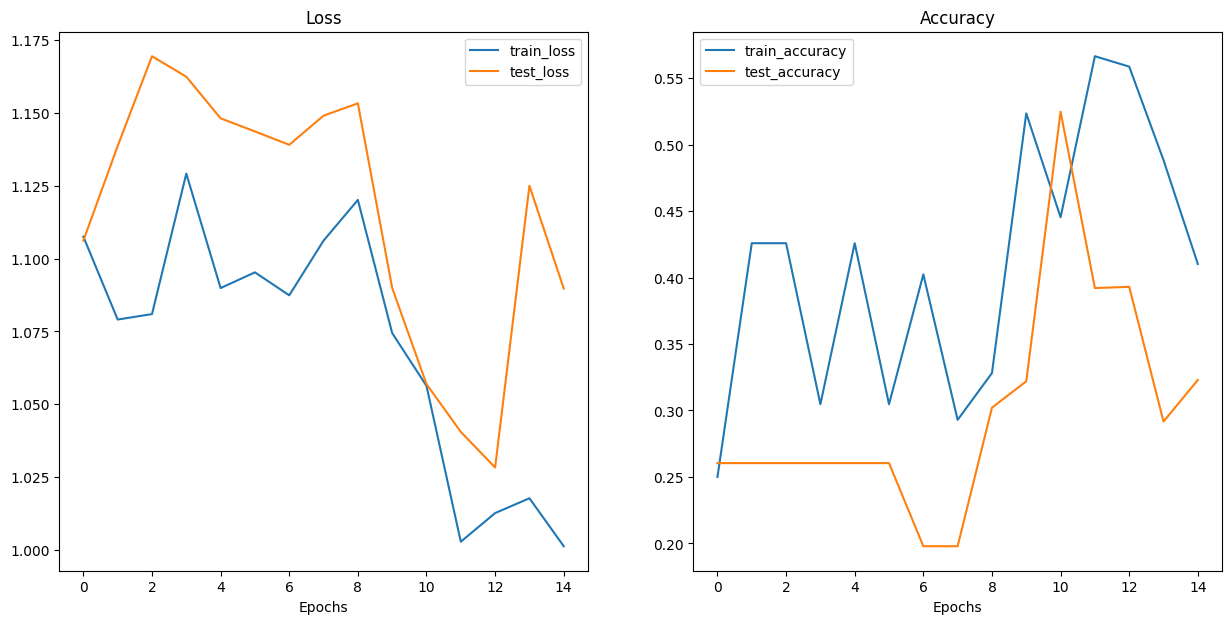

In [60]:
plot_loss_curves(model_1_results)

## 10. Compare model results

In [61]:
import pandas as pd
model_0_df = pd.DataFrame(model_0_results)
model_1_df = pd.DataFrame(model_1_results)

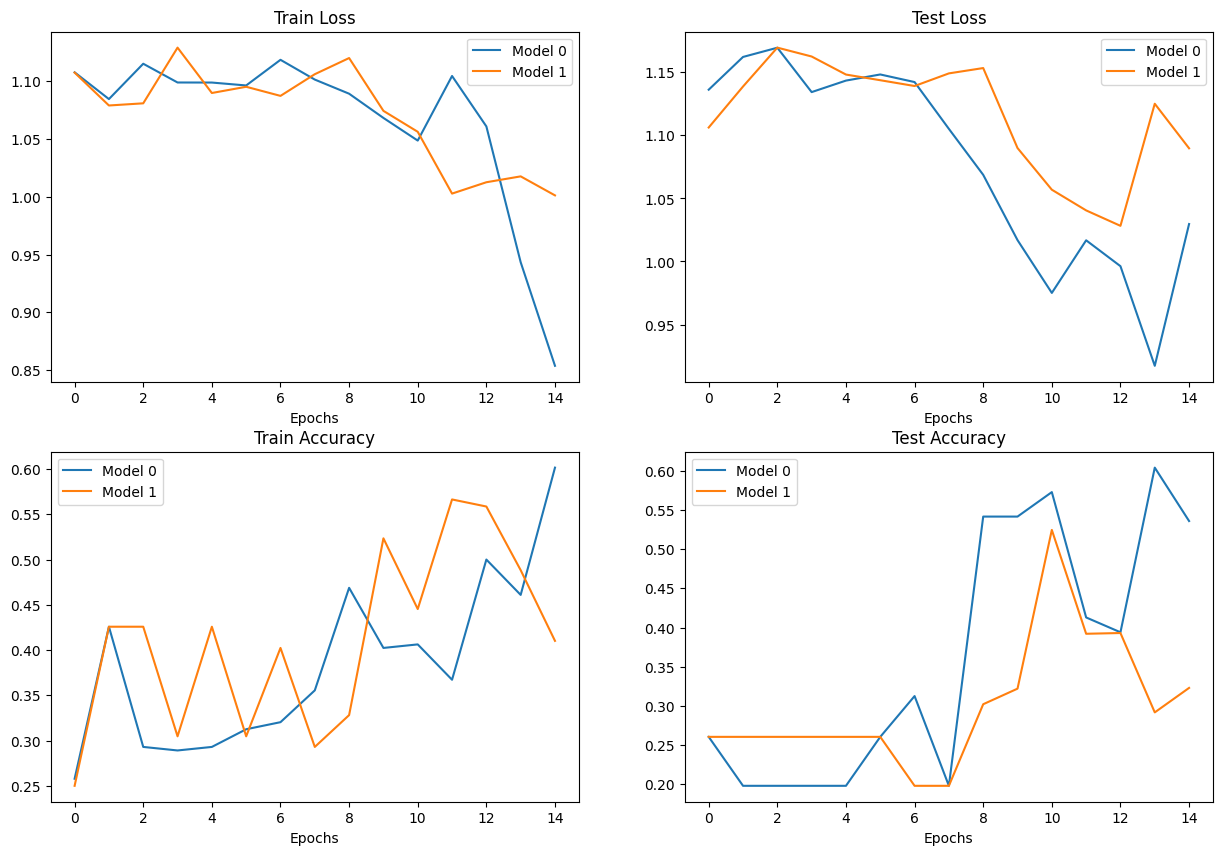

In [62]:
# Setup a plot
plt.figure(figsize=(15, 10))

# Get number of epochs
epochs = range(len(model_0_df))

# Plot train loss
plt.subplot(2, 2, 1)
plt.plot(epochs, model_0_df["train_loss"], label="Model 0")
plt.plot(epochs, model_1_df["train_loss"], label="Model 1")
plt.title("Train Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot test loss
plt.subplot(2, 2, 2)
plt.plot(epochs, model_0_df["test_loss"], label="Model 0")
plt.plot(epochs, model_1_df["test_loss"], label="Model 1")
plt.title("Test Loss")
plt.xlabel("Epochs")
plt.legend()

# Plot train accuracy
plt.subplot(2, 2, 3)
plt.plot(epochs, model_0_df["train_acc"], label="Model 0")
plt.plot(epochs, model_1_df["train_acc"], label="Model 1")
plt.title("Train Accuracy")
plt.xlabel("Epochs")
plt.legend()

# Plot test accuracy
plt.subplot(2, 2, 4)
plt.plot(epochs, model_0_df["test_acc"], label="Model 0")
plt.plot(epochs, model_1_df["test_acc"], label="Model 1")
plt.title("Test Accuracy")
plt.xlabel("Epochs")
plt.legend();

## 11 Make a prediction on a custom image

To make a prediction on a custom image, we can convert our own custom image to a tensor and make sure it's in the right datatype before passing it to our model.

In [63]:
# Download custom a image
import requests

# Setup custom image path
custom_image_path = data_path / "04-pizza-dad.jpeg"

# Download the image if it doesn't already exist
if not custom_image_path.is_file():
  with open(custom_image_path, "wb") as f:
    # When downloading from Github, need to use the "raw" file link
    request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/images/04-pizza-dad.jpeg")
    print(f"Downlading {custom_image_path}...")
    f.write(request.content)

else:
  print(f"{custom_image_path} already exists, skipping download")

data/04-pizza-dad.jpeg already exists, skipping download


## 11.1 Loading in a custom image with PyTorch


PyTorch's `torchvision` has several input and output ("IO" or "io" for short) methods for reading and writing images and video in `torchvsion.io`

In [64]:
import torchvision

# Read in a custom image
custom_image_uint8 = torchvision.io.read_image(str(custom_image_path))

# Print out image data
print(f"Custom image tensor :\n{custom_image_uint8}\n")
print(f"Custom image shape: \n{custom_image_uint8.shape}\n")
print(f"Custom image dtype: \n{custom_image_uint8.dtype}")

Custom image tensor :
tensor([[[154, 173, 181,  ...,  21,  18,  14],
         [146, 165, 181,  ...,  21,  18,  15],
         [124, 146, 172,  ...,  18,  17,  15],
         ...,
         [ 72,  59,  45,  ..., 152, 150, 148],
         [ 64,  55,  41,  ..., 150, 147, 144],
         [ 64,  60,  46,  ..., 149, 146, 143]],

        [[171, 190, 193,  ...,  22,  19,  15],
         [163, 182, 193,  ...,  22,  19,  16],
         [141, 163, 184,  ...,  19,  18,  16],
         ...,
         [ 55,  42,  28,  ..., 107, 104, 103],
         [ 47,  38,  24,  ..., 108, 104, 102],
         [ 47,  43,  29,  ..., 107, 104, 101]],

        [[119, 138, 147,  ...,  17,  14,  10],
         [111, 130, 145,  ...,  17,  14,  11],
         [ 87, 111, 136,  ...,  14,  13,  11],
         ...,
         [ 35,  22,   8,  ...,  52,  52,  48],
         [ 27,  18,   4,  ...,  50,  49,  44],
         [ 27,  23,   9,  ...,  49,  46,  43]]], dtype=torch.uint8)

Custom image shape: 
torch.Size([3, 4032, 3024])

Custom image d

## 11.2 Predicting on custom images with a trained PyTorch model

In [77]:
# Try to make a prediction on image in uint8 format (this will error)
# Will throw an error
"""
model_1.eval()
with torch.inference_mode():
    model_1(custom_image_uint8.to(device))
"""

'\nmodel_1.eval()\nwith torch.inference_mode():\n    model_1(custom_image_uint8.to(device))\n'

In [78]:
# Load in custom image and convert the tensor values to float32
custom_image = torchvision.io.read_image(str(custom_image_path)).type(torch.float32)

# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255

# print out image data
print(f"Custom image tensor:\n{custom_image}\n")
print(f"Custom image shape: {custom_image.shape}\n")
print(f"Custom image dtype: {custom_image.dtype}")

Custom image tensor:
tensor([[[0.6039, 0.6784, 0.7098,  ..., 0.0824, 0.0706, 0.0549],
         [0.5725, 0.6471, 0.7098,  ..., 0.0824, 0.0706, 0.0588],
         [0.4863, 0.5725, 0.6745,  ..., 0.0706, 0.0667, 0.0588],
         ...,
         [0.2824, 0.2314, 0.1765,  ..., 0.5961, 0.5882, 0.5804],
         [0.2510, 0.2157, 0.1608,  ..., 0.5882, 0.5765, 0.5647],
         [0.2510, 0.2353, 0.1804,  ..., 0.5843, 0.5725, 0.5608]],

        [[0.6706, 0.7451, 0.7569,  ..., 0.0863, 0.0745, 0.0588],
         [0.6392, 0.7137, 0.7569,  ..., 0.0863, 0.0745, 0.0627],
         [0.5529, 0.6392, 0.7216,  ..., 0.0745, 0.0706, 0.0627],
         ...,
         [0.2157, 0.1647, 0.1098,  ..., 0.4196, 0.4078, 0.4039],
         [0.1843, 0.1490, 0.0941,  ..., 0.4235, 0.4078, 0.4000],
         [0.1843, 0.1686, 0.1137,  ..., 0.4196, 0.4078, 0.3961]],

        [[0.4667, 0.5412, 0.5765,  ..., 0.0667, 0.0549, 0.0392],
         [0.4353, 0.5098, 0.5686,  ..., 0.0667, 0.0549, 0.0431],
         [0.3412, 0.4353, 0.5333,  ..

## 11.2 Predicting on custom images with a trained PyTorch model

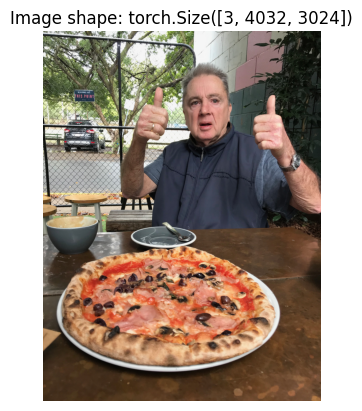

In [79]:
# Plot custom image
plt.imshow(custom_image_uint8.permute(1, 2, 0)) # need to permute image dimensions
plt.title(f"Image shape: {custom_image.shape}")
plt.axis(False);

One way to convert our images to the correct shape is with `torchvision.transforms.Resize()`.

In [80]:
# Create transform pipeline to resize image
custom_image_transform = transforms.Compose([
    transforms.Resize((64, 64))
])

# Transform target image
custom_image_transformed = custom_image_transform(custom_image)

# Print out original shape and new shape
print(f"Original shape: {custom_image.shape}")
print(f"New shape: {custom_image_transformed.shape}")

Original shape: torch.Size([3, 4032, 3024])
New shape: torch.Size([3, 64, 64])


In [84]:
# Will throw an error
"""
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed)
"""

'\nmodel_1.eval()\nwith torch.inference_mode():\n  custom_image_pred = model_1(custom_image_transformed)\n'

Let's put the `custom_image_transformed` on the target device.

In [85]:
model_1.eval()
with torch.inference_mode():
  custom_image_pred = model_1(custom_image_transformed.to(device))

RuntimeError: mat1 and mat2 shapes cannot be multiplied (10x256 and 2560x3)

In [87]:
model_1.eval()
with torch.inference_mode():
  # add an extra dimension to image
  custom_image_transformed_with_batch_size = custom_image_transformed.unsqueeze(dim=0)

  # Print out different shapes
  print(f"Custom image transformed shape: {custom_image_transformed.shape}")
  print(f"Unsqueeze custom image shape: {custom_image_transformed_with_batch_size.shape}")

  # Make a prediction on image with an extra dimension
  custom_image_pred = model_1(custom_image_transformed_with_batch_size)

Custom image transformed shape: torch.Size([3, 64, 64])
Unsqueeze custom image shape: torch.Size([1, 3, 64, 64])


In [89]:
# Custom image prediction
custom_image_pred

tensor([[ 0.2061, -0.2628, -0.4046]])

In [90]:
# Convert from logits to probs to preds

# Print out prediction logits
print(f"Prediction logits: {custom_image_pred}")

# Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
custom_image_pred_probs = torch.softmax(custom_image_pred, dim=1)
print(f"Prediction probabilities: {custom_image_pred_probs}")

# Convert prediction probabilities -> prediction labels
custom_image_pred_label = torch.argmax(custom_image_pred_probs, dim=1)
print(f"Prediction label: {custom_image_pred_label}")

Prediction logits: tensor([[ 0.2061, -0.2628, -0.4046]])
Prediction probabilities: tensor([[0.4611, 0.2885, 0.2504]])
Prediction label: tensor([0])


In [91]:
# Find the predicted label
custom_image_pred_class = class_names[custom_image_pred_label.cpu()] # put pred to CPU otherwise it will error
custom_image_pred_class

'pizza'